# Soft K-means example

In [1]:
library(tidyverse)
library(rstan)
Sys.setenv(RETICULATE_PYTHON = "/nix/store/66p7i56lg3zzp7nj6g0fywb704ihp4iy-python3-3.8.11/bin/python")
library(reticulate)
pd = import("pandas")

── Attaching packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.3     ✔ purrr   0.3.4
✔ tibble  3.1.1     ✔ dplyr   1.0.5
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.4.0     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: StanHeaders

rstan (Version 2.21.2, GitRev: 2e1f913d3ca3)

For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)


Attaching package: ‘rstan’


The following object is m

**To do**
- **Data preparation**
  - Generate cluster data
  - Plot the data
- **Stan model**
  - Code the model in Stan
  - Sample using Stan
  - Plot the clusters found by Stan
  - Conclusion: Did it find all the clusters? (hopefully not)
- **Chainsail model**
  - Code the PDF with `chainsail_helpers`. Reuse Stan's model
  - Upload `probability.py` on GCP (zip + upload)
  - Sample it with Chainsail
  - Download the `results.zip` samples
  - Plot the clusters found by Chainsail
  - Conclusion: Did it find all the clusters? (Hopefully yes)
- **Conclusion**
  - Compare the clusters from Chainsail and Stan


## Data generation
Generate 2D clustered data points

In [54]:
# Read data & reshape into a dataframe
read_delim("data2.txt", delim=" ", col_names=FALSE, col_types=cols(.default=col_double())) %>%
t() %>%
as_tibble() %>%
rename(x=V1, y=V2) -> data_points
data_points

x,y
<dbl>,<dbl>
-0.06799257,-1.256614963
-0.95405819,0.557106929
-0.18406840,0.700378882
-0.96134859,0.248282280
-0.42073952,-0.653614772
0.65157435,0.619918335
-0.05869550,0.150059072
0.25643032,0.652327301
0.16145296,0.893202068


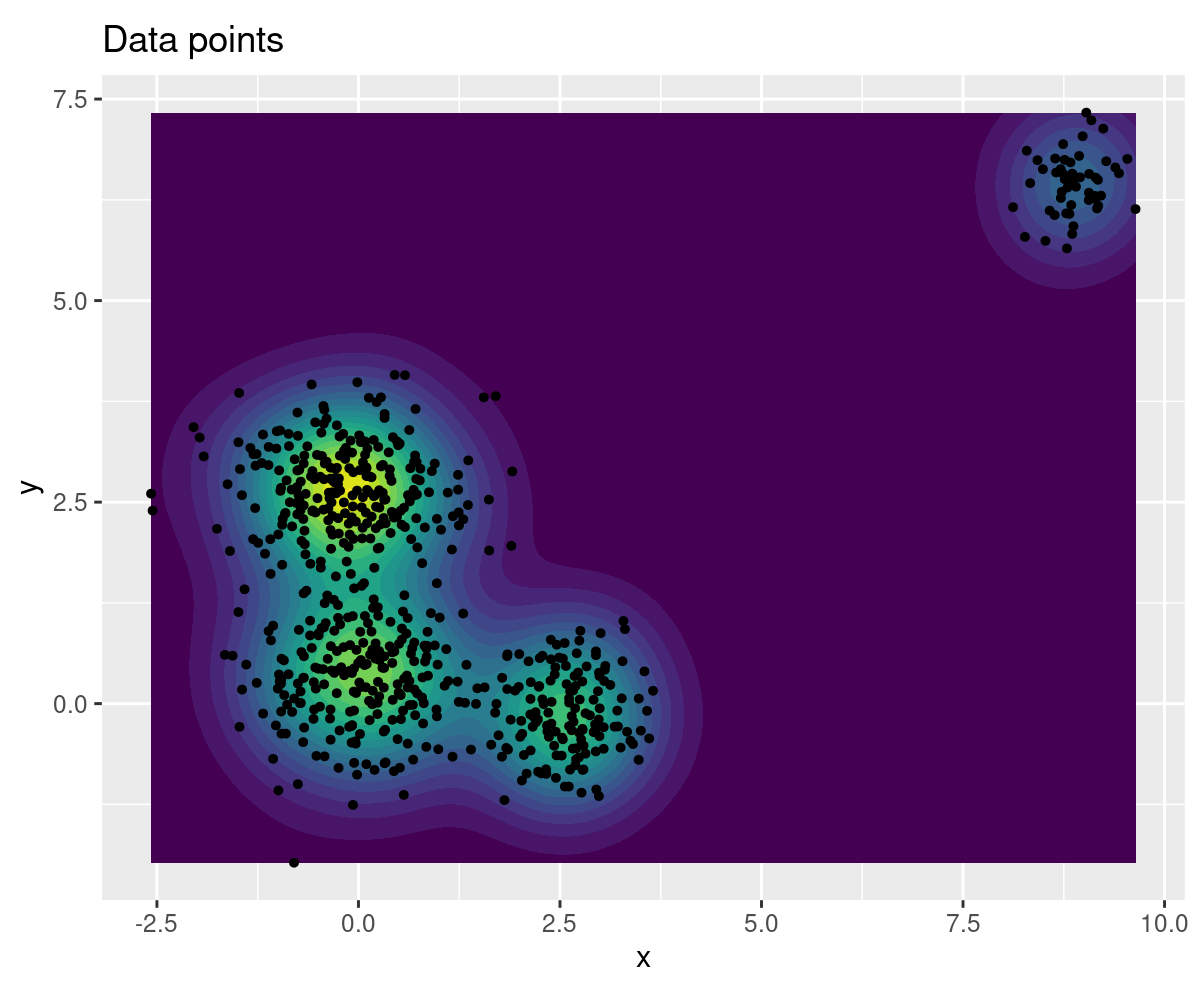

In [55]:
# Plot data points
options(repr.plot.width=6, repr.plot.height=5, repr.plot.res=200)
ggplot(data_points) +
geom_density_2d_filled(aes(x, y), bins=20) +
geom_point(aes(x, y), size=1) +
labs(title="Data points") +
theme(legend.position='none') +
coord_fixed()

## Stan model

### Model definition
Create the model with Stan by definig the data, the parameters to fit, the priors and likelihood. The model is a bivariate normal mixture, with as many modes as clusters we want to find.  
This model is taken from the the [soft K-means example from the Stan documentation](https://mc-stan.org/docs/2_21/stan-users-guide/soft-k-means.html).

In [56]:
# Define Stan model
model_code = "
data {
  int<lower=0> N;  // number of data points
  int<lower=1> D;  // number of dimensions
  int<lower=1> K;  // number of clusters
  vector[D] y[N];  // observations
}
transformed data {
  real<upper=0> neg_log_K;
  neg_log_K = -log(K);
}
parameters {
  vector[D] mu[K]; // cluster means
}
transformed parameters {
  real<upper=0> soft_z[N, K]; // log unnormalized clusters
  for (n in 1:N)
    for (k in 1:K)
      soft_z[n, k] = neg_log_K - 0.5 * dot_self(mu[k] - y[n]);
}
model {
  // prior
  for (k in 1:K)
    mu[k] ~ std_normal();

  // likelihood
  for (n in 1:N)
    target += log_sum_exp(soft_z[n]);
}
"

In [57]:
# Compile the model
model = stan_model(model_code=model_code)

### Posterior distribution sampling

In [58]:
# Prepare input data
N = nrow(data_points)
D = 2
K = 4
y = data_points %>%
    split(1:nrow(.)) %>%
    map(~ c(.x$x, .x$y))
data = list(N, D, K, y)

In [59]:
# Sample the posterior distribution
fit_soft_kmeans = sampling(model, data=data, chains=1, iter=3000, warmup=1000, algorithm="HMC")


SAMPLING FOR MODEL '57d5edbf090e8109c334578dcccb262c' NOW (CHAIN 1).
Chain 1: 
Chain 1: Gradient evaluation took 0.001033 seconds
Chain 1: 1000 transitions using 10 leapfrog steps per transition would take 10.33 seconds.
Chain 1: Adjust your expectations accordingly!
Chain 1: 
Chain 1: 
Chain 1: Iteration:    1 / 3000 [  0%]  (Warmup)
Chain 1: Iteration:  300 / 3000 [ 10%]  (Warmup)
Chain 1: Iteration:  600 / 3000 [ 20%]  (Warmup)
Chain 1: Iteration:  900 / 3000 [ 30%]  (Warmup)
Chain 1: Iteration: 1001 / 3000 [ 33%]  (Sampling)
Chain 1: Iteration: 1300 / 3000 [ 43%]  (Sampling)
Chain 1: Iteration: 1600 / 3000 [ 53%]  (Sampling)
Chain 1: Iteration: 1900 / 3000 [ 63%]  (Sampling)
Chain 1: Iteration: 2200 / 3000 [ 73%]  (Sampling)
Chain 1: Iteration: 2500 / 3000 [ 83%]  (Sampling)
Chain 1: Iteration: 2800 / 3000 [ 93%]  (Sampling)
Chain 1: Iteration: 3000 / 3000 [100%]  (Sampling)
Chain 1: 
Chain 1:  Elapsed Time: 15.7569 seconds (Warm-up)
Chain 1:                7.96057 seconds (Sampli

Warning message:
“Bulk Effective Samples Size (ESS) is too low, indicating posterior means and medians may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#bulk-ess”
Warning message:
“Tail Effective Samples Size (ESS) is too low, indicating posterior variances and tail quantiles may be unreliable.
Running the chains for more iterations may help. See
http://mc-stan.org/misc/warnings.html#tail-ess”


In [60]:
fit_soft_kmeans

Inference for Stan model: 57d5edbf090e8109c334578dcccb262c.
1 chains, each with iter=3000; warmup=1000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=2000.

                  mean se_mean   sd     2.5%      25%      50%      75%
mu[1,1]           8.55    0.00 0.20     8.14     8.41     8.56     8.69
mu[1,2]           6.21    0.00 0.20     5.80     6.08     6.21     6.36
mu[2,1]          -0.20    0.00 0.06    -0.31    -0.24    -0.20    -0.16
mu[2,2]           2.14    0.00 0.08     1.99     2.09     2.14     2.20
mu[3,1]           8.55    0.00 0.21     8.10     8.43     8.56     8.69
mu[3,2]           6.21    0.00 0.22     5.76     6.06     6.21     6.37
mu[4,1]           1.42    0.00 0.09     1.26     1.36     1.42     1.48
mu[4,2]           0.04    0.00 0.07    -0.09     0.00     0.04     0.09
soft_z[1,1]     -66.47    0.03 2.41   -70.96   -68.14   -66.51   -64.88
soft_z[1,2]      -7.17    0.00 0.27    -7.71    -7.36    -7.16    -6.98
soft_z[1,3]     -66.45    0.03

### Analysis of the Mu samples
The Mu samples correspond to the means of the modes of the mixture model. If the sampling is correct, they should be analogous to the centroids of the clusters

In [61]:
# Reshape the mu samples
mus = extract(fit_soft_kmeans)$mu
mus %>%
as_tibble() %>%
mutate(sample_id = row_number()) %>%
gather(key, value, -sample_id) %>%
separate(key, into=c("mode_id", "dimension")) %>%
mutate(dimension = case_when(dimension==1 ~ "x", dimension==2 ~ "y")) %>%
spread(key=dimension, value) -> samples_stan_mu
samples_stan_mu

sample_id,mode_id,x,y
<int>,<chr>,<dbl>,<dbl>
1,1,8.64598859,6.3598697505
1,2,-0.22014614,2.2342756738
1,3,8.13707345,5.7500202971
1,4,1.28268251,0.0736504098
2,1,8.65623551,5.8882389179
2,2,-0.06941826,2.1573193009
2,3,8.63456001,6.8148692192
2,4,1.44513189,0.0685937856
3,1,8.35236307,5.7368775718


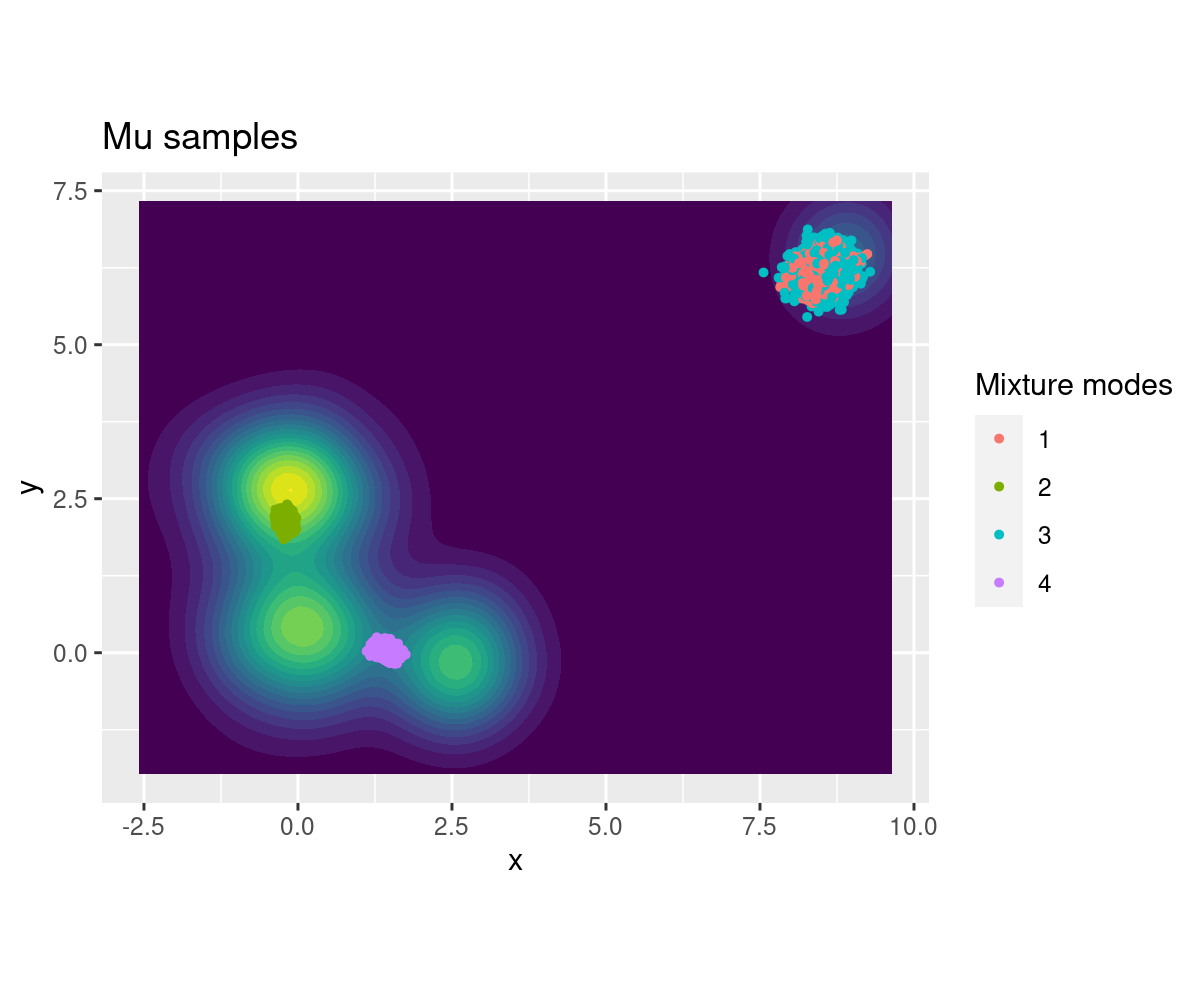

In [62]:
# Plot MU samples
options(repr.plot.width=6, repr.plot.height=5, repr.plot.res=200)
ggplot(data_points) +
geom_density_2d_filled(aes(x, y), bins=20, show.legend=F) +
geom_point(
    data=samples_stan_mu,
    aes(x, y, color=mode_id),
    size=1
) +
labs(title="Mu samples", color="Mixture modes") +
coord_fixed()

### Attribution of the data points to clusters
In addition to the Mu, we get samples from the `soft_z` parameters. They encode probabilities for each data point to have been generated by each of the 9 modes of the model. 

In [63]:
# Get median soft z (=median)
soft_zs = extract(fit_soft_kmeans)$soft_z
soft_zs %>%
apply(c(2,3), median) %>%                       # Keep the median logprob of all samples
apply(c(1), function(x) which(x==max(x)) ) %>%  # Attribute the point to the most probable cluster
as_tibble() %>%
transmute(cluster=as.character(value)) -> samples_stan_median_softz
data_points %>%
bind_cols(samples_stan_median_softz) -> data_points_clustered
data_points_clustered

x,y,cluster
<dbl>,<dbl>,<chr>
-0.06799257,-1.256614963,4
-0.95405819,0.557106929,2
-0.18406840,0.700378882,2
-0.96134859,0.248282280,2
-0.42073952,-0.653614772,4
0.65157435,0.619918335,4
-0.05869550,0.150059072,4
0.25643032,0.652327301,4
0.16145296,0.893202068,2


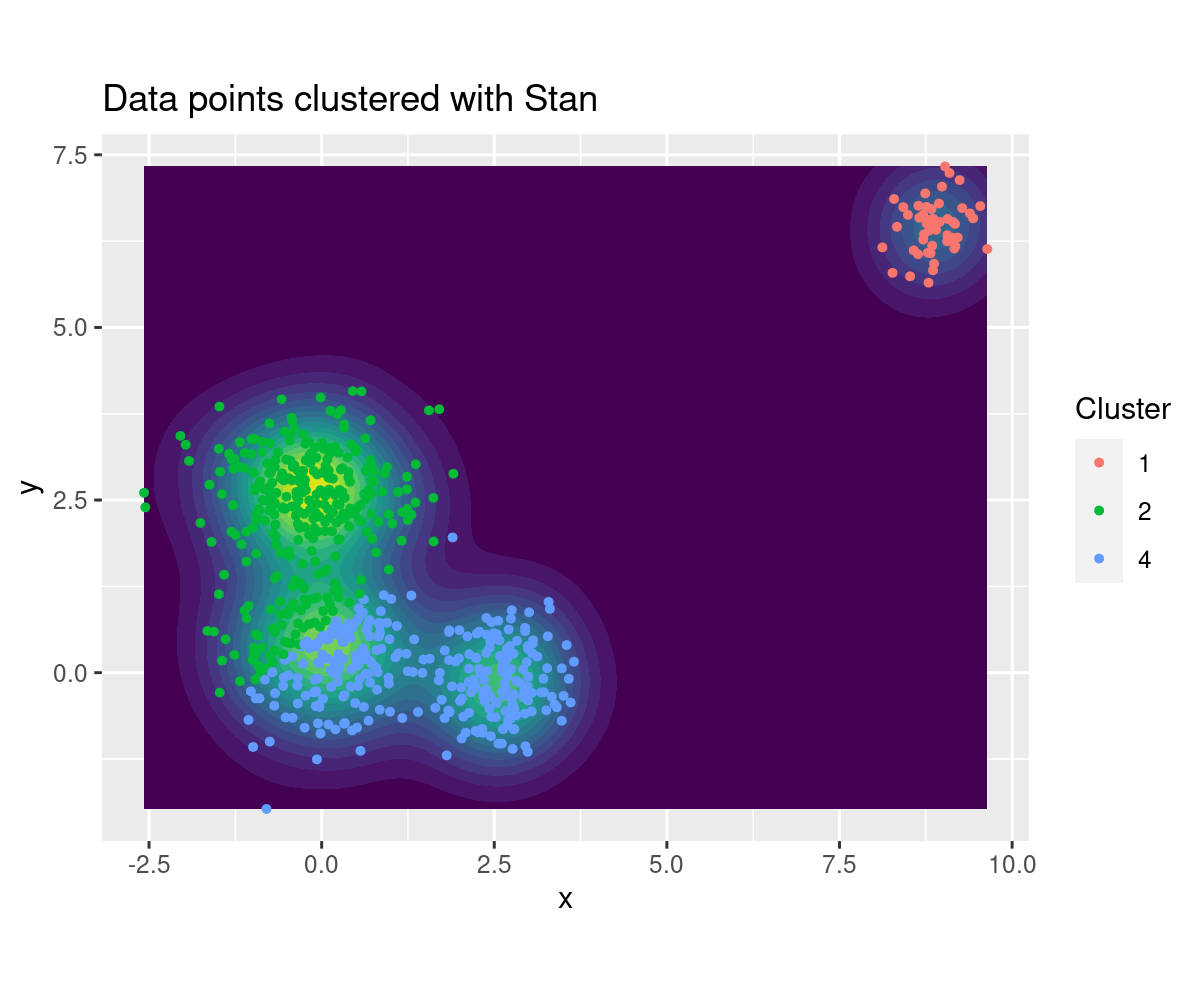

In [64]:
# Plot samples
options(repr.plot.width=6, repr.plot.height=5, repr.plot.res=200)
ggplot(data_points_clustered) +
geom_density_2d_filled(aes(x, y), bins=20, show.legend=F) +
geom_point(aes(x, y, color=cluster), size=1) +
labs(
    title="Data points clustered with Stan",
    color="Cluster"
) +
coord_fixed()

## Chainsail model
- Code the PDF with `chainsail_helpers`. Reuse Stan's model
- Upload `probability.py` on GCP (zip + upload)
- Sample it with Chainsail
- Download the `results.zip` samples
- Plot the clusters found by Chainsail
- Conclusion: Did it find all the clusters? (Hopefully yes)

In [65]:
samples_chainsail = pd$read_pickle("run2/optimization_run0/samples/samples_replica1_500-1000.pickle")

In [66]:
# Cast samples to tibble
samples_chainsail %>%
map_dfr(function(elt) {
    elt %>%
    as_tibble %>%
    mutate(dim = rep(c('x', 'y'), length.out = nrow(.))) %>%
    mutate(mode_id = rep(1:(nrow(.)/2), each = 2))
}, .id="sample_id") %>%
spread(dim, value)-> samples_chainsail2
samples_chainsail2

sample_id,mode_id,x,y
<chr>,<int>,<dbl>,<dbl>
1,1,-0.16748840,2.59404567
1,2,-0.14693012,0.48496166
1,3,2.42489078,-0.02232567
1,4,8.69926795,6.43069968
10,1,-0.11820700,2.46916491
10,2,-0.05535691,0.63864070
10,3,2.25051224,-0.03674889
10,4,8.72897350,6.58284877
100,1,-0.12651373,0.72719381


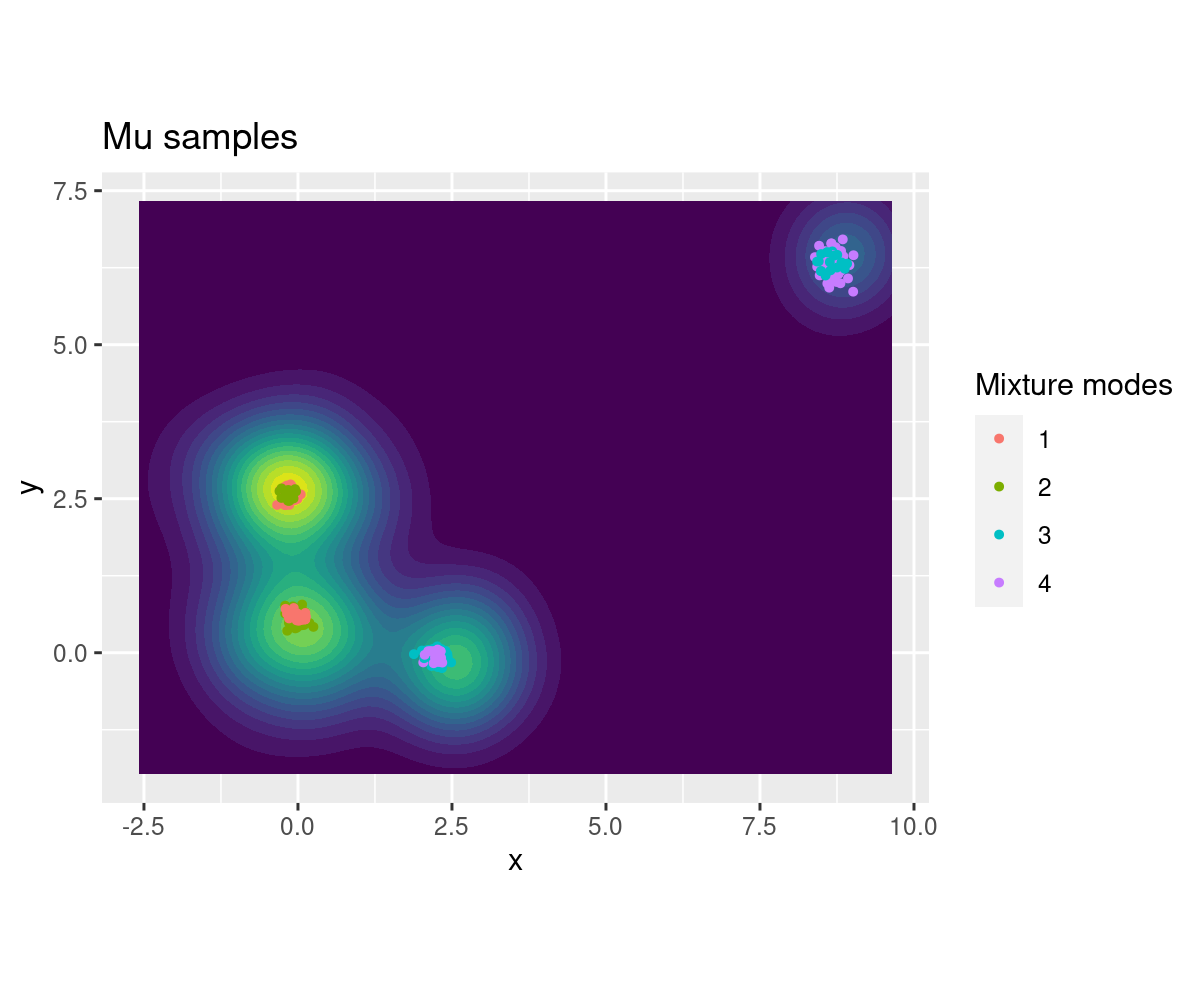

In [67]:
# Plot MU samples
options(repr.plot.width=6, repr.plot.height=5, repr.plot.res=200)
ggplot(data_points) +
geom_density_2d_filled(aes(x, y), bins=20, show.legend=F) +
geom_point(
    data=samples_chainsail2,
    aes(x, y, color=as.character(mode_id)),
    size=1
) +
labs(title="Mu samples", color="Mixture modes") +
coord_fixed()